In [1]:
from sympy import *
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../')
import RandomMatrix as RM

%matplotlib inline
sns.set()

np.random.seed(140)

Suppose we have a 2 by 2 GOE with $X$ and $Y$ as the diagonal terms and $Z$ as the off diagonal term. Recall that $X,Y \sim N(0,1)$ and $Z \sim N(0, \frac{1}{2})$

In [2]:
X, Y, Z = symbols("X Y Z")
A = Matrix(np.array([[X,Z], [Z,Y]]))
A

Matrix([
[X, Z],
[Z, Y]])

We can easily find the characteristic equation for this general matrix

In [3]:
λ = symbols("λ")
characteristic_eq = det(A - λ*np.eye(2))
characteristic_eq                      

-Z**2 + (X - 1.0*λ)*(Y - 1.0*λ)

If we solve to find the eigenvalues and subtract the bigger eigenvalue from the smaller one we get the following expression for $\Delta$

In [4]:
λ_2, λ_1 = solve(characteristic_eq,λ)
Δ = λ_1 - λ_2
Δ

2.0*sqrt(0.25*X**2 - 0.5*X*Y + 0.25*Y**2 + Z**2)

So $\Delta = \sqrt{(X-Y)^2 + 4Z^2}$. If we define $T=X-Y$, then $T \sim N(0, 2)$. We can also define $S=2Z$, and note $S \sim N(0,2)$. We can write $\Delta = \sqrt{T^2 + S^2}$. Thus $\Delta$ is the square root of the sum of squares for iid normals, which brings us to our main result

$$\Delta \sim \text{Rayleigh}(\sqrt{2})$$

In [5]:
trials = 5000
Δs = []
for _ in range(trials):
    A = RM.Generate_GOE(2)
    λs, V = np.linalg.eigh(A)
    λ_1, λ_2 = λs[1], λs[0]
    Δs.append(λ_1 - λ_2)

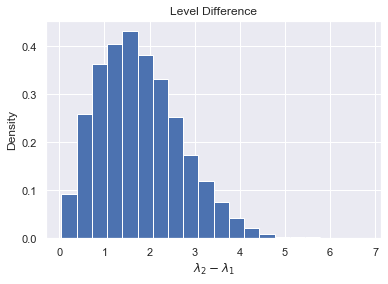

In [6]:
plt.ylabel("Density")
plt.xlabel("$\lambda_2 - \lambda_1$")
plt.title("Level Difference")
plt.hist(Δs, bins=20, density=True);

Suppose we want to study what heppens to the spaces between eigenvalues as $N \rightarrow \infty$. For now, let's examine what heppens for $N=100$.

In [7]:
trials = 1000
Δs = []
matrix_size = 100
for _ in range(trials):
    A = RM.Generate_GOE(matrix_size) 
    λs, V = np.linalg.eigh(A)
    eig_spaces = [λs[i+1] - λs[i] for i in range(matrix_size-1)]
    Δs.extend(eig_spaces)

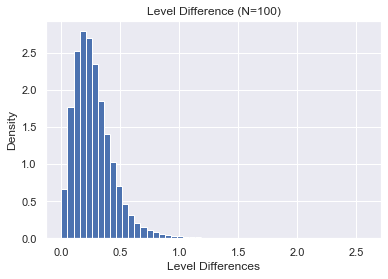

In [8]:
plt.ylabel("Density")
plt.xlabel("Level Differences")
plt.title("Level Difference (N=100)")
plt.hist(Δs, bins=50, density=True);

Next we'll try $N=300$.

In [9]:
trials = 1000
Δs = []
matrix_size = 300
for _ in range(trials):
    A = RM.Generate_GOE(matrix_size) 
    λs, V = np.linalg.eigh(A)
    eig_spaces = [λs[i+1] - λs[i] for i in range(matrix_size-1)]
    Δs.extend(eig_spaces)

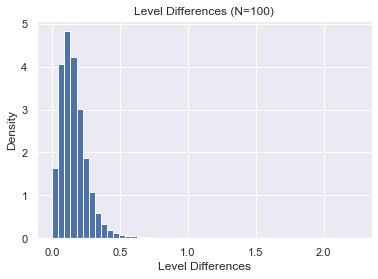

In [10]:
plt.ylabel("Density")
plt.xlabel("Level Differences")
plt.title("Level Differences (N=100)")
plt.hist(Δs, bins=50, density=True);

Clearly, and perhaps unsurprisingly, the spacings become smaller and tend towards 0. In order to study the behavior of spacings asymptotically, we need to "unfold" the eigenvalues so that the spacings have mean 1.

# Unfolding of Spectra

Suppose we have a collection of eigenvalues $\lambda_1, \lambda_2, ... , \lambda_n$ and we are interested in studying their level distances $\lambda_{i+1} - \lambda_i$. As seen above, these level distances will tend to 0 as the dimension of the Gaussian Ensemble gets large. Thus to get interesting results, we must scale (or "unfold") the eigenvalues so the mean spacing is equal to 1. To find this scaling factor, we use the results of the Wigner's Semicircle law section to define the mean cumulative spectral density

$$F_{N, \beta}(\lambda) = N \int_{-\sqrt{2 \beta N}}^{\lambda} \rho_{\sqrt{2 \beta N}}(t) dt $$

Recall from the previous section the closed form solution to the indefinite integral

In [11]:
t = symbols("t")
N, β = symbols("N β", positive=True)
σ = 2/(pi*(2*β*N)) * sqrt((2*β*N) - t**2)
Λ_N_β = integrate(N*σ, t)
Λ_N_β

(N*β*asin(sqrt(2)*t/(2*sqrt(N)*sqrt(β))) + t*sqrt(2*N*β - t**2)/2)/(pi*β)

We can find a closed form expression for $F(\lambda)$

In [12]:
λ = symbols("λ")
F_λ = Λ_N_β.subs(t, λ) - Λ_N_β.subs(t, -sqrt(2*β*N))
F_λ

N/2 + (N*β*asin(sqrt(2)*λ/(2*sqrt(N)*sqrt(β))) + λ*sqrt(2*N*β - λ**2)/2)/(pi*β)

Thus we get 

$ F_{N, \beta}(\lambda) = \begin{cases} 
      0 & \lambda \leq -\sqrt{2 \beta N} \\
      \frac{N}{2} + \frac{1}{\pi \beta} \left(N \beta sin^{-1}(\frac{\sqrt{2}\lambda}{2 \sqrt{N \beta}}) + \frac{\lambda \sqrt{2N\beta - \lambda^2}}{2}\right) & \lambda \in (-\sqrt{2 \beta N}, \sqrt{2 \beta N}) \\
      N & \lambda \geq \sqrt{2 \beta N}
   \end{cases}$


Note the above expression is the for cumulative spectral density for $\lambda \in [-\sqrt{2 \beta N}, \sqrt{2 \beta N}]. $We can now define $\bar{\lambda}_i := F(\lambda_i)$. The level spacings of these new values will have unit mean in expectation.

In [13]:
def F(eig, size, beta):
    if eig <= -np.sqrt(2*beta*size):
        return 0
    if eig >= np.sqrt(2*beta*size):
        return size
    else:
        # F_λ is defined outside this function
        return float(F_λ.subs(β, beta).subs(N, size).subs(λ, eig).evalf())

Below is a demonstration for a GOE

In [14]:
matrix_size = 300
A = RM.Generate_GOE(matrix_size) 
λs, V = np.linalg.eigh(A)
λ_bar = [F(eigenvalue, matrix_size, 1) for eigenvalue in λs] 
eig_spaces = [λ_bar[i+1] - λ_bar[i] for i in range(matrix_size-1)]
np.mean(eig_spaces)

1.0025488914947855

Below is a demonstration for a GUE

In [15]:
matrix_size = 300
A = RM.Generate_GUE(matrix_size) 
λs, V = np.linalg.eigh(A)
λ_bar = [F(eigenvalue, matrix_size, 2) for eigenvalue in λs] 
eig_spaces = [λ_bar[i+1] - λ_bar[i] for i in range(matrix_size-1)]
np.mean(eig_spaces)

0.999554510091682

# Wigner's Surmise

Wigner's Surmise says that the density of level distances for an unfolded set of eigenvalues can be approximated by

$$p_{\beta}(s) = a_{\beta} s^{\beta} e^{- b_{\beta} s^2} $$

where 

$$ a_{\beta} = 2 \frac{\left(\Gamma(\frac{\beta + 2}{2})\right)^{\beta + 1}}{\left(\Gamma(\frac{\beta + 1}{2})\right)^{\beta + 2}}, \ b_{\beta} = \frac{\left(\Gamma(\frac{\beta + 2}{2})\right)^{2}}{\left(\Gamma(\frac{\beta + 1}{2})\right)^{2}}$$

Note this is an approximation and does not necessarily converge for large $N$.

In [16]:
gamma = lambda x: scipy.special.gamma(x)
def wigner_surmise(s, beta):
    a = 2*(gamma((beta+2)/2))**(beta+1)/(gamma((beta+1)/2))**(beta + 2)
    b = (gamma((beta+2)/2))**2/(gamma((beta+1)/2))**2
    return a * (s**beta) * np.exp(-b*s**2)

We will test this approximation with $100 \times 100$ GOEs.

In [17]:
matrix_size = 100
trials = 100
all_eig_spaces = []
for _ in range(trials):
    A = RM.Generate_GOE(matrix_size) 
    λs, V = np.linalg.eigh(A)
    λ_bar = [F(eigenvalue, matrix_size, 1) for eigenvalue in λs] 
    eig_spaces = [λ_bar[i+1] - λ_bar[i] for i in range(matrix_size-1)]
    all_eig_spaces.extend(eig_spaces)

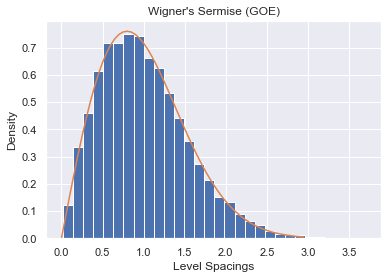

In [18]:
plt.ylabel("Density")
plt.xlabel("Level Spacings")
plt.title("Wigner's Sermise (GOE)")
plt.hist(all_eig_spaces, bins=30, density=True)
t = np.arange(0., 3, 0.05)
wigner_curve = wigner_surmise(t, 1)
plt.plot(t, wigner_curve);

Now we do the same test for GUEs

In [19]:
matrix_size = 100
trials = 100
all_eig_spaces = []
for _ in range(trials):
    A = RM.Generate_GUE(matrix_size) 
    λs, V = np.linalg.eigh(A)
    λ_bar = [F(eigenvalue, matrix_size, 2) for eigenvalue in λs] 
    eig_spaces = [λ_bar[i+1] - λ_bar[i] for i in range(matrix_size-1)]
    all_eig_spaces.extend(eig_spaces)

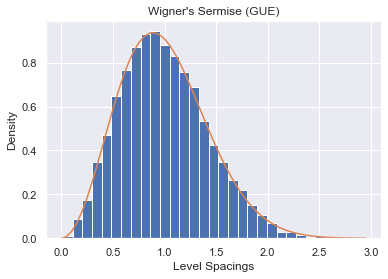

In [20]:
plt.ylabel("Density")
plt.xlabel("Level Spacings")
plt.title("Wigner's Sermise (GUE)")
plt.hist(all_eig_spaces, bins=30, density=True)
t = np.arange(0., 3, 0.05)
wigner_curve = wigner_surmise(t, 2)
plt.plot(t, wigner_curve);